# Siamese Network

Took inspiration from https://github.com/radekosmulski/whale/blob/master/siamese_network_prototype.ipynb

In [181]:
import fastai
from fastai import *
from fastai.vision import *
import torch
from torch import nn
print(f'fastai version: {fastai.__version__}')
print(f'torch version: {torch.__version__}')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
# to stop fastai from printing out "UserWarning: Tensor is int32: upgrading to int64;"

verbose = True  # print out extra detail stuff

fastai version: 1.0.41
torch version: 1.0.0


In [2]:
# global setting
bs = 16
num_workers = 3
# num_workers = 0  # if using kaggle kernel
sz = 224  # image size

data_fp = Path('data')
data_train = 'train'
data_test = 'test'
data_label = 'train.csv'
# crop_fp = data_fp/'cropping.txt'

procedure
* remove all new whales?
* add code that takes into account classes without single images
    * if classes with single image, return a data augmented version or different image
    * if new whale return a random image. 
    
    
 

# Looking at the Data

In [3]:
labels = pd.read_csv(data_fp/data_label)
print(labels.shape)
print(f'Number of classes: {len(labels.Id.unique()):,}')
labels.head()

(25361, 2)
Number of classes: 5,005


,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [4]:
cls_count = labels.Id.value_counts()
cls_one = cls_count[cls_count == 1]
print(f'Number of classes with only one image: {len(cls_one):,}')
print(f'Single image accounts for: {len(cls_one)/len(cls_count):.0%}')
cls_one = cls_one.index.tolist()
cls_one[:5]

Number of classes with only one image: 2,073
Single image accounts for: 41%


['w_73e5b74', 'w_3789389', 'w_2570b49', 'w_52182de', 'w_e026c82']

In [5]:
cls_count.head()  # most common class is new whale

new_whale    9664
w_23a388d      73
w_9b5109b      65
w_9c506f6      62
w_0369a5c      61
Name: Id, dtype: int64

## Train/Validation Split

In [6]:
# pre-determined train/validation split because of the usual situation of having 
# classes with only one data point. In addition, to be able to compare different
# model performance. Code for split is in first_attempt.ipynb section Stratified Split
train_idx = pd.read_csv(data_fp/'train_idx.csv')['index'].tolist()

In [7]:
train_idx[:10]

[21280, 16349, 4289, 13468, 25308, 20273, 12062, 7736, 16585, 10457]

In [8]:
## assess that the number of class are all accounted for in the training indexing
assert len(labels.loc[train_idx, 'Id'].unique()) == len(labels.Id.unique())
print('Number of class {}: {}'.format(len(labels.loc[train_idx, 'Id'].unique()), len(labels['Id'].unique())))
print('Percent of training split: {:.0%}'.format(len(train_idx)/labels.shape[0]))

Number of class 5005: 5005
Percent of training split: 76%


In [9]:
# Fastai expect validation index rather than training set index
val_idx = list(set(labels.index.tolist()) - set(train_idx))
len(val_idx)

6020

# Create Data Bunch

In [10]:
tfms = get_transforms(do_flip=False, max_zoom=1)

In [11]:
# using fastai for splitting, importing, and transforming of the data
src = (ImageItemList.from_df(df=labels, path=data_fp, cols='Image', folder=data_train)
                    .split_by_idx(val_idx)
                    .label_from_df(cols='Id')
                    .add_test_folder(test_folder='test')
                    .transform(tfms, size=sz, resize_method=ResizeMethod.SQUISH))
if verbose: print(src)

LabelLists;

Train: LabelList
y: CategoryList (19341 items)
[Category w_f48451c, Category w_c3d896a, Category w_20df2c5, Category new_whale, Category new_whale]...
Path: data
x: ImageItemList (19341 items)
[Image (3, 700, 1050), Image (3, 325, 758), Image (3, 497, 1050), Image (3, 525, 1050), Image (3, 525, 1050)]...
Path: data;

Valid: LabelList
y: CategoryList (6020 items)
[Category w_64404ac, Category w_a6f9d33, Category new_whale, Category w_cb622a2, Category w_d3b46e7]...
Path: data
x: ImageItemList (6020 items)
[Image (3, 450, 1050), Image (3, 667, 1000), Image (3, 600, 1050), Image (3, 285, 1050), Image (3, 347, 1050)]...
Path: data;

Test: LabelList
y: EmptyLabelList (7960 items)
[EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel ]...
Path: .
x: ImageItemList (7960 items)
[Image (3, 522, 1050), Image (3, 390, 683), Image (3, 700, 1050), Image (3, 324, 1050), Image (3, 457, 686)]...
Path: data


In [125]:
tmp.show??

Signature: tmp.show(ax: matplotlib.axes._axes.Axes, **kwargs)
Source:   
    def show(self, ax:plt.Axes, **kwargs): 
        "Subclass this method if you want to customize the way this `ItemBase` is shown on `ax`."
        ax.set_title(str(self))
File:      c:\users\boki\anaconda3\lib\site-packages\fastai\core.py
Type:      method


In [97]:
class PairImgDataset(Dataset):
    def __init__(self, ds, p=0.5):
        """
        Args:
            ds (LabelList): a tuple containing a PIL Image and a Category class
            p (float): probability of returning a same image class sample
        """
        self.ds = ds
        self.cls = ds.y.items  # class's int value
        self.p = p
        
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, idx):
        same_cls = np.random.choice([0,1], p=[1-self.p, self.p])  # have control over balancing the data
        return self.same_class(idx) if same_cls else self.diff_class(idx)
    
# TODO: Remove print out statements

    def same_class(self, idx):
        img1 = self.ds[idx]  # image + class
        
        print('=========Same============')
        print(f'image1: {idx}') # for testing
        
        if img1[1].obj == 'new_whale' or img1[1].obj in cls_one:
            # new_whale and classes with single image are paired with its augmented self
            img2 = self.ds[idx][0]  # fastai return a new augmented image at each access
        else:
            idx2 = np.where(self.cls[idx] == self.cls)[0]  # idx of images with same class including itself
            np.random.shuffle(idx2)  # randomize idx
            img2 = self.ds[idx2[0]][0]
            print(f'image2: {idx2[0]}') # for testing
        return self.combine_img(img1[0], img2, 1)
    
    def diff_class(self, idx):
        img1 = self.ds[idx]
        idxs = self.cls.tolist()
        
        print('=========Diff============')
        print(f'image1: {idx}') # for testing
        
        if img1[1].obj != 'new_whale' or img1[1].obj not in cls_one:
            # remove same class images from possible selection
            idxs_same = np.where(self.cls[idx] == self.cls)[0]
            idxs = list(set(idxs) - set(idxs_same))
        
        np.random.shuffle(idxs)
        img2 = self.ds[idxs[0]][0]
        print(f'image2: {idxs[0]}')
        return self.combine_img(img1[0], img2, 0)
        
    def combine_img(self, img1, img2, same_cls):
        # Image size does not change until data is accessed or displayed
        return [Image(img1.data), Image(img2.data)], same_cls

In [157]:
def plot_pair(imagepair, ax=None):
    # fuse image and extend the width
    img = torch.cat((imagepair[0][0].data, imagepair[0][1].data), 2).numpy().transpose(1,2,0)
    if ax is None:
        _, ax = plt.subplots()
    
    ax.imshow(img)
    ax.axis('off')
    ax.set_title('Same' if imagepair[1] else 'Diff')

def plot_multipair(data, r=2, c=2, figsize= (12,6)):
    _, axes = plt.subplots(r, c, figsize=figsize)
    for i in range(r):
        for j in range(c):
            idx = np.random.randint(len(data))
            plot_pair(data[idx], ax=axes[i,j])

=========Diff============
image1: 12297
image2: 978
=========Diff============
image1: 2914
image2: 3381
=========Same============
image1: 11455
=========Same============
image1: 3384


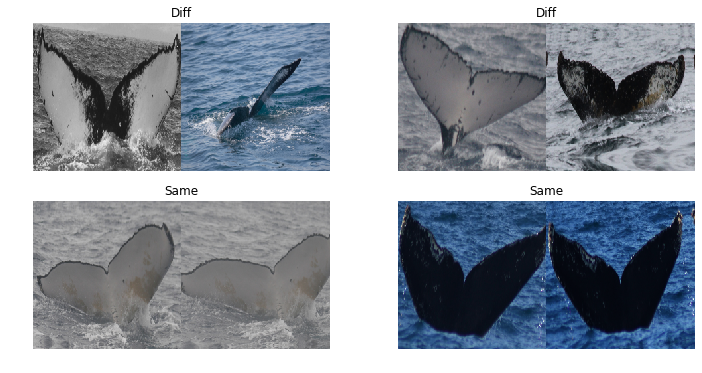

In [162]:
plot_multipair(PairImgDataset(src.train), 2, 2)

In [164]:
trn_dl = DataLoader(PairImgDataset(src.train),
                    batch_size=bs,
                    shuffle=True,
                    num_workers=num_workers)
valid_dl = DataLoader(PairImgDataset(src.valid),
                      batch_size=bs,
                      shuffle=True,
                      num_workers=num_workers)

data_bunch = ImageDataBunch(trn_dl, valid_dl)

In [168]:
def normalize_batch(batch):
    stat_tensors = [torch.tensor(l).cuda() for l in imagenet_stats]
    return [normalize(batch[0][0], *stat_tensors), normalize(batch[0][1], *stat_tensors)], batch[1]

In [171]:
data_bunch.add_tfm(normalize_batch)

In [170]:
class SiameseNetwork(nn.Module):
    def __init__(self, arch=models.resnet18):
        super(SiameseNetwork, self).__init__()
        self.cnn = create_body(arch)
        nf = fastai.callbacks.hooks.num_features_model(self.cnn) * 2
        self.head = nn.linear(nf, 1)
    
    def forward(self, img1, img2):
        

ModuleNotFoundError: No module named 'functional'

In [189]:
fastai.callbacks.hooks.num_features_model(create_body(models.resnet50))

2048

torchvision.models.resnet.ResNet

In [188]:
create_cnn??

Signature:
create_cnn(
    ['data: fastai.basic_data.DataBunch', 'arch: Callable', 'cut: Union[int, Callable] = None', 'pretrained: bool = True', 'lin_ftrs: Union[Collection[int], NoneType] = None', 'ps: Union[float, Collection[float]] = 0.5', 'custom_head: Union[torch.nn.modules.module.Module, NoneType] = None', 'split_on: Union[Callable, Collection[Collection[torch.nn.modules.module.Module]], NoneType] = None', 'bn_final: bool = False', '**kwargs: Any'],
) -> fastai.basic_train.Learner
Source:   
def create_cnn(data:DataBunch, arch:Callable, cut:Union[int,Callable]=None, pretrained:bool=True,
                lin_ftrs:Optional[Collection[int]]=None, ps:Floats=0.5,
                custom_head:Optional[nn.Module]=None, split_on:Optional[SplitFuncOrIdxList]=None,
                bn_final:bool=False, **kwargs:Any)->Learner:
    "Build convnet style learners."
    meta = cnn_config(arch)
    body = create_body(arch, pretrained, cut)
    nf = num_features_model(body) * 2
    head = custom_h

In [172]:
create_body??

Signature:
create_body(
    ['arch: Callable', 'pretrained: bool = True', 'cut: Union[int, NoneType] = None', 'body_fn: Callable[[torch.nn.modules.module.Module], torch.nn.modules.module.Module] = None'],
)
Source:   
def create_body(arch:Callable, pretrained:bool=True, cut:Optional[int]=None, body_fn:Callable[[nn.Module],nn.Module]=None):
    "Cut off the body of a typically pretrained `model` at `cut` or as specified by `body_fn`."
    model = arch(pretrained)
    if not cut and not body_fn: cut = cnn_config(arch)['cut']
    return (nn.Sequential(*list(model.children())[:cut]) if cut
            else body_fn(model) if body_fn else model)
File:      c:\users\boki\anaconda3\lib\site-packages\fastai\vision\learner.py
Type:      function


In [173]:
num_features_model??

Object `num_features_model` not found.


In [175]:
fastai.callbacks.hooks.num_features_model

AttributeError: module 'fastai' has no attribute 'hooks'

In [183]:
tmp_cnn = create_body(models.resnet34)

In [185]:
type(tmp_cnn)

torch.nn.modules.container.Sequential

In [186]:
tmp_cnn

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, ker

In [187]:
create_head??

Signature:
create_head(
    ['nf: int', 'nc: int', 'lin_ftrs: Union[Collection[int], NoneType] = None', 'ps: Union[float, Collection[float]] = 0.5', 'bn_final: bool = False'],
)
Source:   
def create_head(nf:int, nc:int, lin_ftrs:Optional[Collection[int]]=None, ps:Floats=0.5, bn_final:bool=False):
    "Model head that takes `nf` features, runs through `lin_ftrs`, and about `nc` classes."
    lin_ftrs = [nf, 512, nc] if lin_ftrs is None else [nf] + lin_ftrs + [nc]
    ps = listify(ps)
    if len(ps)==1: ps = [ps[0]/2] * (len(lin_ftrs)-2) + ps
    actns = [nn.ReLU(inplace=True)] * (len(lin_ftrs)-2) + [None]
    layers = [AdaptiveConcatPool2d(), Flatten()]
    for ni,no,p,actn in zip(lin_ftrs[:-1],lin_ftrs[1:],ps,actns):
        layers += bn_drop_lin(ni,no,True,p,actn)
    if bn_final: layers.append(nn.BatchNorm1d(lin_ftrs[-1], momentum=0.01))
    return nn.Sequential(*layers)
File:      c:\users\boki\anaconda3\lib\site-packages\fastai\vision\learner.py
Type:      function
